In [ ]:
%pip install -q -U langchain_openai langchain_core langgraph

## Langfuse Tracing

In [17]:
from my_utils import setup_langfuse_tracer
from my_config import MyConfig

langfuse_handler = setup_langfuse_tracer()
my_config = MyConfig()

## OpenAI Authentication

In [18]:
import os

# Please setp your own key.
os.environ["OPENAI_API_KEY"] = my_config.OPENAI_API_KEY

## Get the LLM Models

In [19]:
# from langchain_openai import ChatOpenAI
# vision_llm = ChatOpenAI(model="gpt-4o")
# llm = ChatOpenAI(model="gpt-4o")

# from langchain_ollama.llms import OllamaLLM
from langchain_ollama import ChatOllama
remote_url = f"https://{my_config.OLLAMA_INFERENCE_RUNPOD_ID}-11434.proxy.runpod.net"
vision_llm = ChatOllama(
    base_url=remote_url
    # , model='deepseek-r1:32b'
    , model='llama4:scout'
)
llm = ChatOllama(
    base_url=remote_url
    # , model='deepseek-r1:32b'
    , model='llama4:scout'
)

## Define the Tools

In [20]:
import base64
from langchain_core.messages import HumanMessage

def extract_text(img_path: str) -> str:
    """
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
    """
    all_text = ""
    try:

        # Read image and encode as base64
        with open(img_path, "rb") as image_file:
            image_bytes = image_file.read()

        image_base64 = base64.b64encode(image_bytes).decode("utf-8")

        # Prepare the prompt including the base64 image data
        message = [
            HumanMessage(
                content=[
                    {
                        "type": "text",
                        "text": (
                            "Extract all the text from this image. "
                            "Return only the extracted text, no explanations."
                        ),
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{image_base64}"
                        },
                    },
                ]
            )
        ]

        # Call the vision-capable model
        response = vision_llm.invoke(message, config={"langfuse_handler": langfuse_handler})

        # Append extracted text
        all_text += response.content + "\n\n"

        return all_text.strip()
    except Exception as e:
        # You can choose whether to raise or just return an empty string / error message
        error_msg = f"Error extracting text: {str(e)}"
        print(error_msg)
        return ""
    

def divide(a: int, b: int) -> float:
    """Divide a and b."""
    return a / b

## Bind tools to LLM

In [21]:
tools = [
    divide,
    extract_text
]
# llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)
llm_with_tools = llm.bind_tools(
    tools
    # , parallel_tool_calls=False
)

## Defining Agent's State
This state is a little more complex than the previous ones we have seen. AnyMessage is a class from Langchain that defines messages, and add_messages is an operator that adds the latest message rather than overwriting it with the latest state.

This is a new concept in LangGraph, where you can add operators in your state to define the way they should interact together.

In [22]:
from typing import TypedDict, Annotated, Optional
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    # The document provided
    input_file: Optional[str]  # Contains file path (PDF/PNG)
    messages: Annotated[list[AnyMessage], add_messages]

## The nodes

In [23]:
from langchain_core.messages import SystemMessage

def assistant(state: AgentState):
    # System message
    textual_description_of_tool="""
extract_text(img_path: str) -> str:
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.

divide(a: int, b: int) -> float:
    Divide a and b
    Args:
        a: The numerator (int).
        b: The denominator (int).
    Returns:
        The result of the division (float).
"""
    image=state["input_file"]
    sys_msg = SystemMessage(content=f"You are a helpful butler named Alfred that serves Mr. Wayne and Batman. You can analyse documents and run computations with provided tools:\n{textual_description_of_tool} \n You have access to some optional images. Currently the loaded image is: {image}")

    return {
        "messages": [llm_with_tools.invoke([sys_msg] + state["messages"])],
        "input_file": state["input_file"]
    }

## The ReAct Pattern: How I Assist Mr. Wayne
Allow me to explain the approach in this agent. The agent follows what’s known as the ReAct pattern (Reason-Act-Observe)

1. **Reason** about his documents and requests
2. **Act** by using appropriate tools
3. **Observe** the results
4. **Repeat** as necessary until I’ve fully addressed his needs

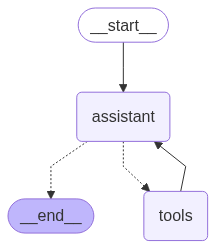

In [24]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

# The graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message requires a tool, route to tools
    # Otherwise, provide a direct response
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show the butler's thought process
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

We define a tools node with our list of tools. The assistant node is just our model with bound tools. We create a graph with assistant and tools nodes.

We add a tools_condition edge, which routes to End or to tools based on whether the assistant calls a tool.

Now, we add one new step:

We connect the tools node back to the assistant, forming a loop.

- After the assistant node executes, tools_condition checks if the model’s output is a tool call.
- If it is a tool call, the flow is directed to the tools node.
- The tools node connects back to assistant.
- This loop continues as long as the model decides to call tools.
- If the model response is not a tool call, the flow is directed to END, terminating the process.

## The Butler in Action
### Example 1: Simple Calculations

Here is an example to show a simple use case of an agent using a tool in LangGraph.

In [26]:
messages = [HumanMessage(content="Divide 6790 by 5")]
messages = react_graph.invoke(
    {
        "messages": messages
        , "input_file": None
    }
    , config={"callbacks": [langfuse_handler]}
)
# Show the messages
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Divide 6790 by 5
================================== Ai Message ==================================
Tool Calls:
  divide (f65d6184-4e10-400c-a3f1-22847524d16a)
 Call ID: f65d6184-4e10-400c-a3f1-22847524d16a
  Args:
    a: 6790
    b: 5
================================= Tool Message =================================
Name: divide

1358.0
================================== Ai Message ==================================
Tool Calls:
  divide (2250d765-d81d-4672-a6d9-67c4f1d0e092)
 Call ID: 2250d765-d81d-4672-a6d9-67c4f1d0e092
  Args:
    a: 6790
    b: 5
================================= Tool Message =================================
Name: divide

1358.0
================================== Ai Message ==================================

The provided function and its output indicate that the result of dividing 6790 by 5 is 1358.0.


### Example 2: Analyzing Master Wayne’s Training Documents
When Master Wayne leaves his training and meal notes:

**Note here, While using remote Ollama for inference, we can't use local files in the inference. So here we are providing the image content directly. So the `extract_test` tool is of no use in this case**

================================ Human Message =================================

[{'type': 'text', 'text': "According to the note provided by Mr. Wayne in the provided images. What's the list of items I should buy for the dinner menu?"}, {'type': 'image_url', 'image_url': {'url': ''}}]
================================== Ai Message ==================================

The dinner menu includes grass-fed local sirloin steak, organic spinach, and oven-baked golden potatoes. To prepare this meal, you would need to buy the following items:

*   Sirloin steak (grass-fed)
*   Organic spinach
*   Potatoes
*   Cooking oil or butter for preparation

These ingredients are essential for creating the dinner menu as described.

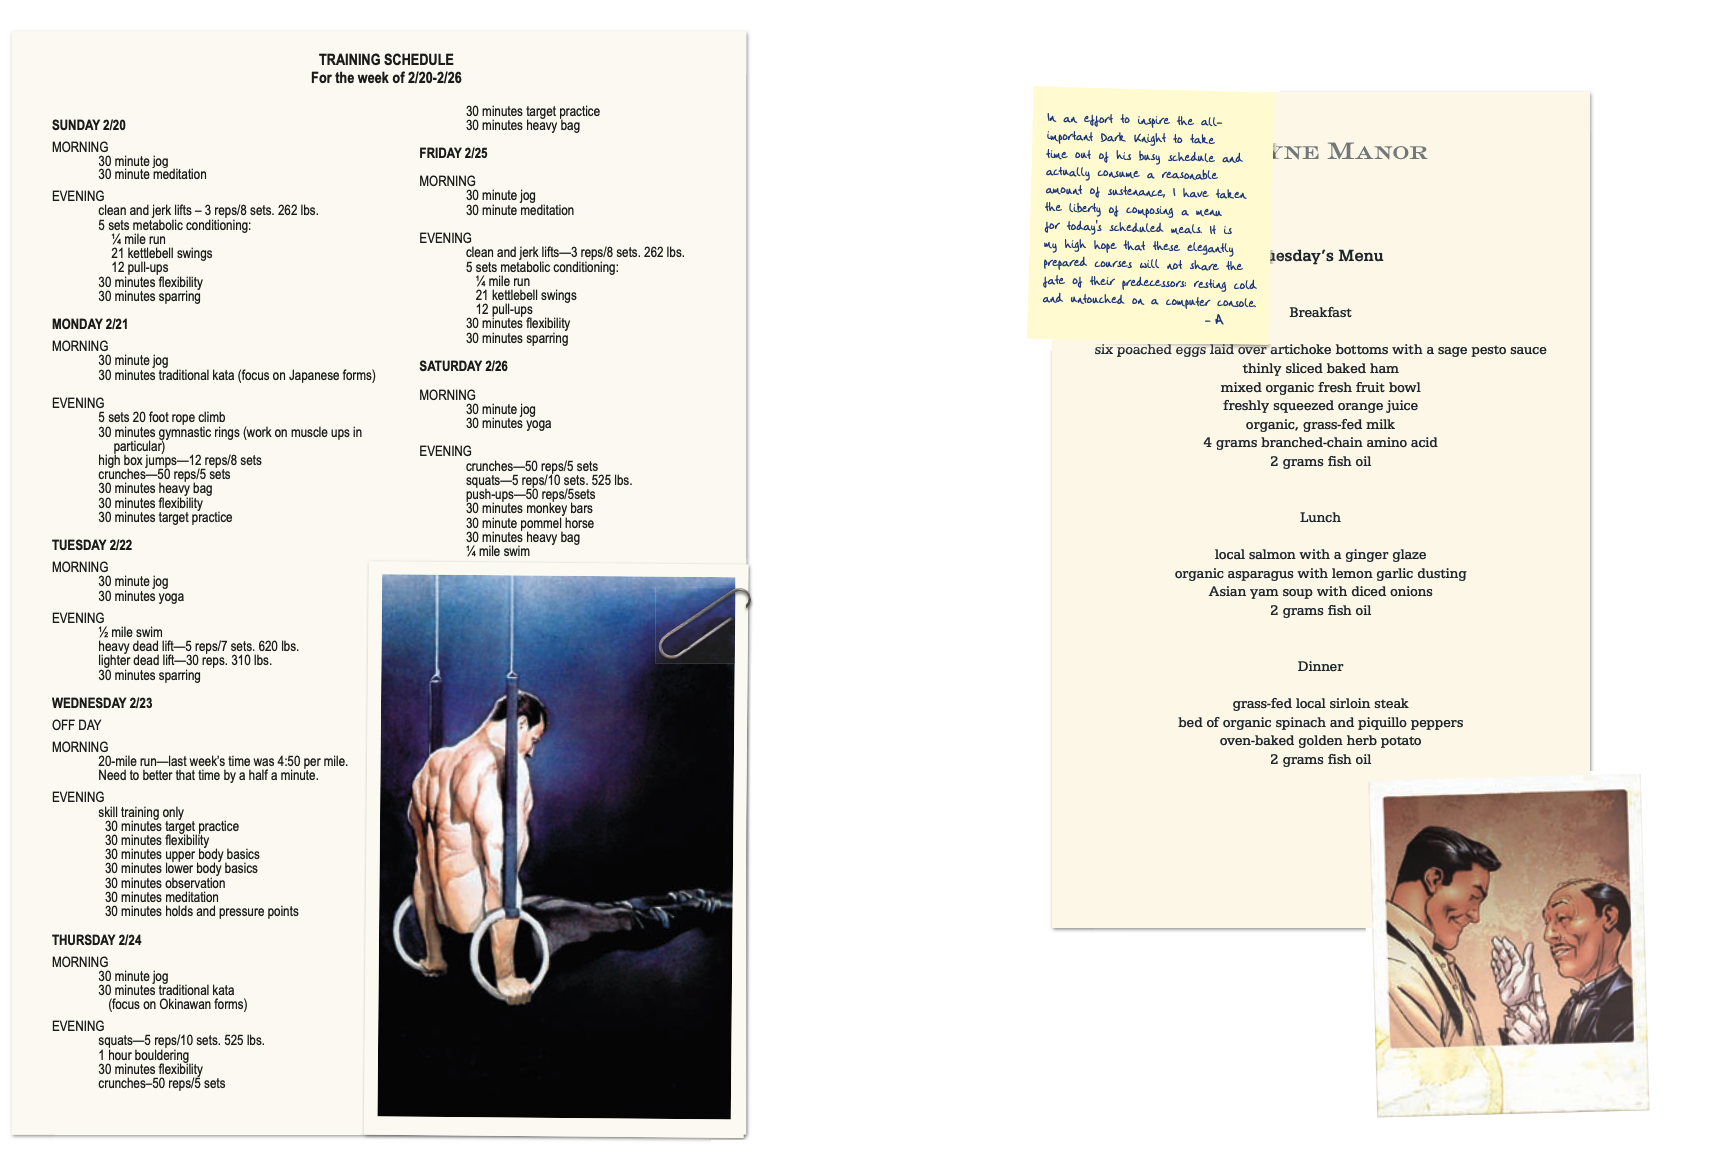

In [35]:
with open("data/Batman_training_and_meals.png", "rb") as img_file:
    img_base64 = base64.b64encode(img_file.read()).decode("utf-8")

messages = [HumanMessage(
    content=[
        {
            "type": "text",
            "text": (
                "According to the note provided by Mr. Wayne in the provided images. What's the list of items I should buy for the dinner menu?"
            ),
        },
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/png;base64,{img_base64}"
            },
        },
    ]
)]
messages = react_graph.invoke(
    {
        "messages": messages
        , "input_file": None
    }
    , config={"callbacks": [langfuse_handler]}
)
# Show the messages
for m in messages['messages']:
    m.pretty_print()